In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import random
import math

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision
from torchvision import utils
import torchvision.transforms as T
from torchvision.datasets import CelebA

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED=42
IMG_SIZE=256

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value

Experiment details:

Obtaining image reconstruction
- GAN model - StyleGAN
- Encoder - CLIP Image Encoder
- dataset: FFHQ - 256x256

Important comment about StyleGAN: it has multiple 'spaces' which could be used for mapping of inversion. 

We will start with the simplest mapping to $z$-space and see where it goes. Then mode on to w-space. In addition to tricks with learning we will try additional architectures.

Some papers
1. mapping to z, w, w+ spaces - benefit of editability, but poor reconstruction:
   - https://arxiv.org/abs/2004.04467
   - https://arxiv.org/abs/2008.00951
   - https://arxiv.org/abs/2102.02766
   - https://arxiv.org/abs/2004.00049
2. mappings to F_k (feature space, output of k-th convolutional layer of StyleGAN) - great reconstruction, poor editability:
   - https://arxiv.org/abs/2212.14359
   - https://arxiv.org/abs/2109.06590
   - https://arxiv.org/abs/2202.02183

In [8]:
# !rm -rf /root/.cache/torch_extensions

## Prepare pretrained models (StyleGAN and CLIP)

checkpoint taken from here: https://github.com/rosinality/style-based-gan-pytorch

In [2]:
from stylegan import StyledGenerator

SIZE=256
CHECKPOINT="checkpoints/stylegan-256px-new.model"

# prepare generator
G = StyledGenerator(512).to(DEVICE)
G.load_state_dict(
    torch.load(CHECKPOINT, map_location=DEVICE)["g_running"]
)
G.eval()

# freeze gradients
for p in G.parameters():
    p.requires_grad = False

In [3]:
from torchvision import utils
from torch import tensor

@torch.no_grad()
def get_mean_style(generator, device):
    mean_style = None

    for i in range(10):
        style = generator.mean_style(torch.randn(1024, 512).to(device))

        if mean_style is None:
            mean_style = style

        else:
            mean_style += style

    mean_style /= 10
    return mean_style


def sample(generator, step, mean_style, n_sample, device, z=None, w=None):
    if z is None:
        z = torch.randn(n_sample, 512).to(device)
    image = generator(
        input=z,
        w=w,
        step=step,
        alpha=1,
        mean_style=mean_style,
        style_weight=0.7,
    )
    
    return image


def predict(generator, n_samples=1, seed=False):
    if seed:
        torch.manual_seed(SEED)
    mean_style = get_mean_style(generator, DEVICE)
    step = int(math.log(SIZE, 2)) - 2
    img = sample(generator, step, mean_style, n_samples, DEVICE)

    return img


def predict_from_z(generator, n_samples, z, seed=False):
    if seed:
        torch.manual_seed(SEED)
    mean_style = get_mean_style(generator, DEVICE)
    step = int(math.log(SIZE, 2)) - 2

    img = sample(generator, step, mean_style, n_samples, DEVICE, z=z)

    return img


def predict_from_w(generator, n_samples, w, seed=False):
    """Given latent code w, generate images right from w-space"""
    if seed:
        torch.manual_seed(SEED)
    mean_style = get_mean_style(generator, DEVICE)
    step = int(math.log(SIZE, 2)) - 2

    img = sample(generator, step, mean_style, n_samples, DEVICE, w=w)
    return img


def plot_images(images, nrow=5):
    grid = utils.make_grid(images, nrow=nrow, padding=2, pad_value=2, normalize=True)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    plt.figure(figsize=(25, 5))
    plt.axis('off')
    plt.imshow(ndarr)
    plt.show()

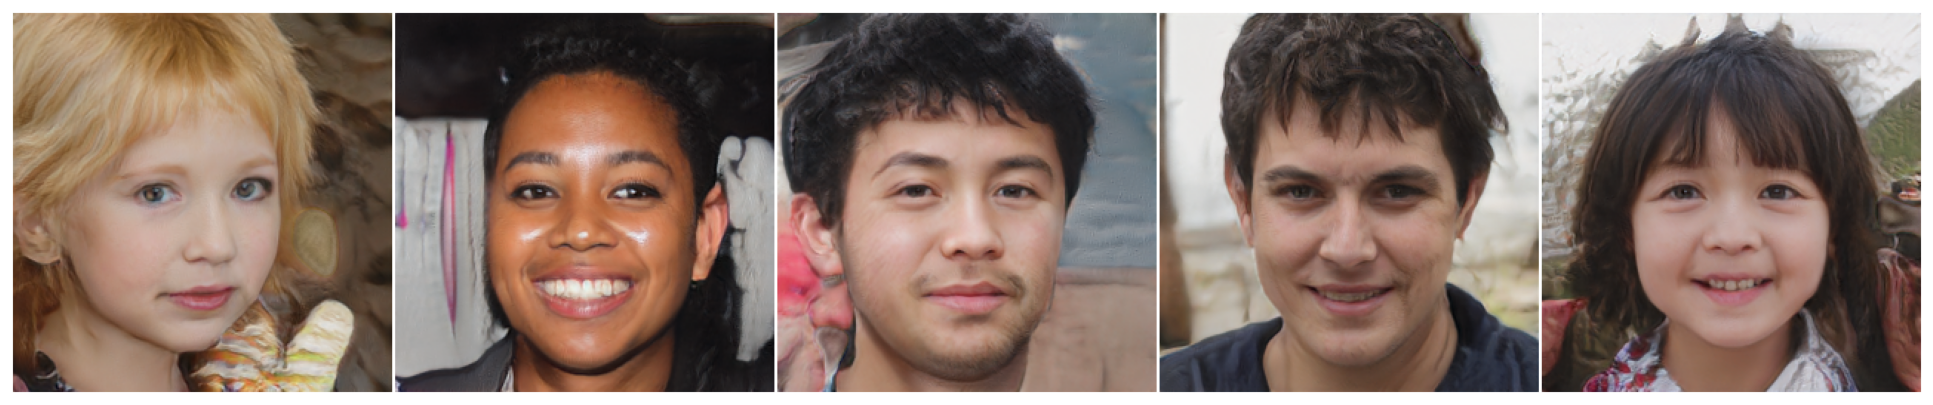

In [60]:
plot_images(predict(G, 5, seed=True), 5)

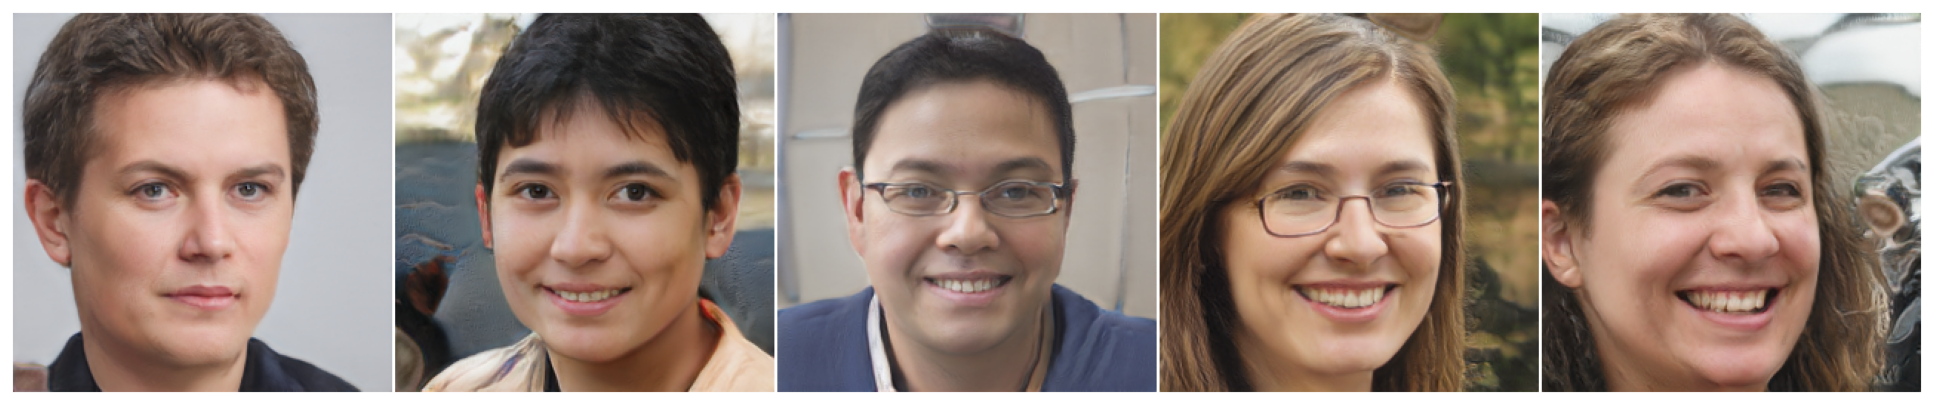

In [68]:
plot_images(predict_from_z(G, 5, torch.randn(5, 512).to(DEVICE)), 5)

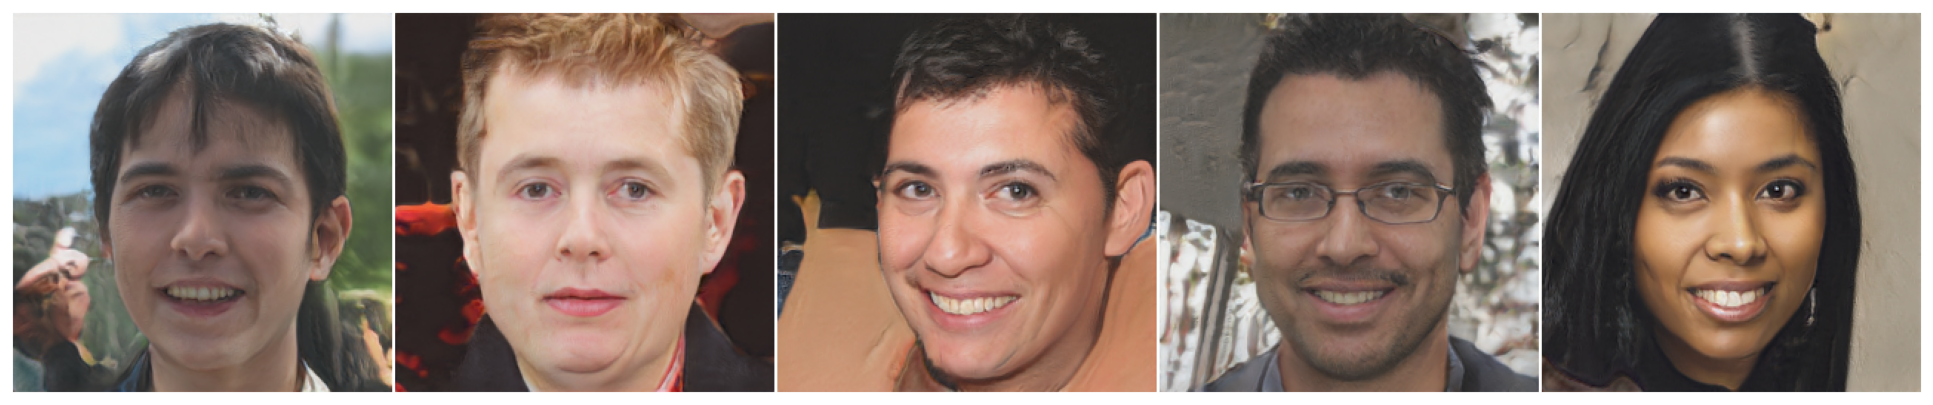

In [86]:
plot_images(predict_from_w(G, 5, w=torch.randn(5, 512).to(DEVICE)), 5)

In [4]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

for p in model.parameters():
    p.requires_grad = False

In [5]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean=0.5, std=0.5):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

denormalize = NormalizeInverse(0.5, 0.5)
to_pil = T.ToPILImage()

n_px=model.visual.input_resolution
clip_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

## Training of map

In [17]:
# architectures
class MLPMap(nn.Module):
    """Learnable projection from y-space to z-space"""
    def __init__(self, n_hidden_layers, hidden_dim, y_dim, z_dim):
        super().__init__()
        layers = [nn.Linear(y_dim, hidden_dim)]
        for _ in range(n_hidden_layers):
            layers += [nn.GELU(), nn.Linear(hidden_dim, hidden_dim)]
        layers += [nn.GELU(), nn.Linear(hidden_dim, z_dim)]
        self.projection = nn.Sequential(*layers)

    def forward(self, y):
        return self.projection(y)


class MLPMapv2(nn.Module):
    def __init__(self, n_hidden_layers, hidden_dim, y_dim, z_dim):
        super().__init__()
        layers1 = [nn.Linear(y_dim, hidden_dim)]
        layers2 = []
        for i in range(n_hidden_layers // 2):
            layers1 += [nn.GELU(), nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.4)]
            layers2 += [nn.GELU(), nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25)]
  
        head = [nn.GELU(), nn.Linear(hidden_dim, z_dim)]
        self.projection1 = nn.Sequential(*layers1)
        self.projection2 = nn.Sequential(*layers2)
        self.head = nn.Sequential(*head)
    
    def forward(self, y):
        p = self.projection1(y)
        return self.head(self.projection2(p) + p)
        

In [19]:
import os
from PIL import Image
from IPython.display import clear_output

pil2tensor = T.functional.pil_to_tensor
eval_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    T.ToTensor(),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

def train_latent_map_sg_clip(
        mapping: nn.Module, 
        sg_generator: nn.Module, 
        encoder: nn.Module, 
        loss_fn, # loss function used on latents
        optimizer, 
        num_iters=5000, 
        eval_iters=1000, # ? 
        batch_size=512, 
        ema=None,
        image_augmentations=None,
        args=AttributeDict(),
        plot_every=None,
    ):
    sg_generator.eval()
    encoder.eval()
    mapping.train()

    loss_hist = []
    p_bar = tqdm(range(num_iters))
    for i in p_bar:
        optimizer.zero_grad()
        z = torch.randn((batch_size, z_dim), device=DEVICE)
        with torch.no_grad():
            images = denormalize(predict_from_z(sg_generator, batch_size, z))
            # Saving images for later reconstruction loss
            if args.loss_reconstruction is not None:
                images_original = images.clone()
            if image_augmentations is not None:
                images = image_augmentations(images)
            images = clip_transform(images)
            y = encoder.encode_image(images).squeeze(0).float()
            if args.noise_lantents:
                y += args.nl_scale*torch.randn_like(y)
                
        if args.adv_loss_used:
            loss = loss_fn(mapping, y, z)
        else:
            z_hat = mapping(y)
            loss = loss_fn(z_hat, z)
            
        if args.loss_reconstruction is not None:
            imgs_hat = predict_from_z(sg_generator, batch_size, z_hat)
            imgs_hat = denormalize(imgs_hat)
            loss += args.rec_loss_scale * args.loss_reconstruction(imgs_hat, images_original)
        
        loss.backward()
        optimizer.step()
        if ema is not None:
            ema.update()
        
        loss_hist.append(loss.item())
        p_bar.set_postfix(loss=loss.item())
        
        if plot_every is not None:
            if i % plot_every == 0:
                clear_output(wait=True)
                visualize_inversion("data/celeba_val", mapping, sg_generator, encoder)
        
    return loss_hist, mapping


@torch.no_grad()
def visualize_inversion(eval_samples, mapping, generator, encoder, saved_weights_path=None):
    if saved_weights_path is not None:
        mapping.load_state_dict(torch.load(saved_weights_path))

    # read images from folder
    images = []
    for file in os.listdir(eval_samples):
        if file.split('.')[-1] not in ['jpg', 'jpeg', 'png']: continue
        img = Image.open(eval_samples + '/' + file)
        images.append(img)
    eval_samples = images
    eval_samples = [eval_transform(img) for img in eval_samples]
    plot_images(eval_samples, nrow=5)
    
    mapping.eval()
    images=torch.stack(eval_samples).to(DEVICE)
    y = encoder.encode_image(images).squeeze(0).float()
    z_hat = mapping(y)
    inv_samples = denormalize(predict_from_z(generator, len(eval_samples), z_hat)).cpu()

    #eval_samples = torch.stack(eval_samples) # for vis. function
    plot_images(inv_samples, nrow=5)
    mapping.train()    

In [ ]:
z_dim=512
y_dim=512
n_hidden=4
hidden_dim=512
mapping = MLPMap(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)

# training utils
optimizer = optim.Adam(mapping.parameters(), lr=2e-3)
loss_fn = F.mse_loss
batch_size = 32

args = AttributeDict()
args.noise_lantents = True
args.nl_scale = 1e-1
args.adv_loss_used = False 
args.rec_loss_scale = 0. # loss(x, G(z))
args.loss_reconstruction = None

loss_hist, mapping = train_latent_map_sg_clip(
    mapping=mapping,
    sg_generator=G,
    encoder=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_iters=10_000,
    batch_size=batch_size,
    image_augmentations=T.RandomErasing(),
    args=args,
    plot_every=50
)

In [23]:
torch.save(mapping.state_dict(), f"model_weights/sg1/mlp_mapping_4.pth")

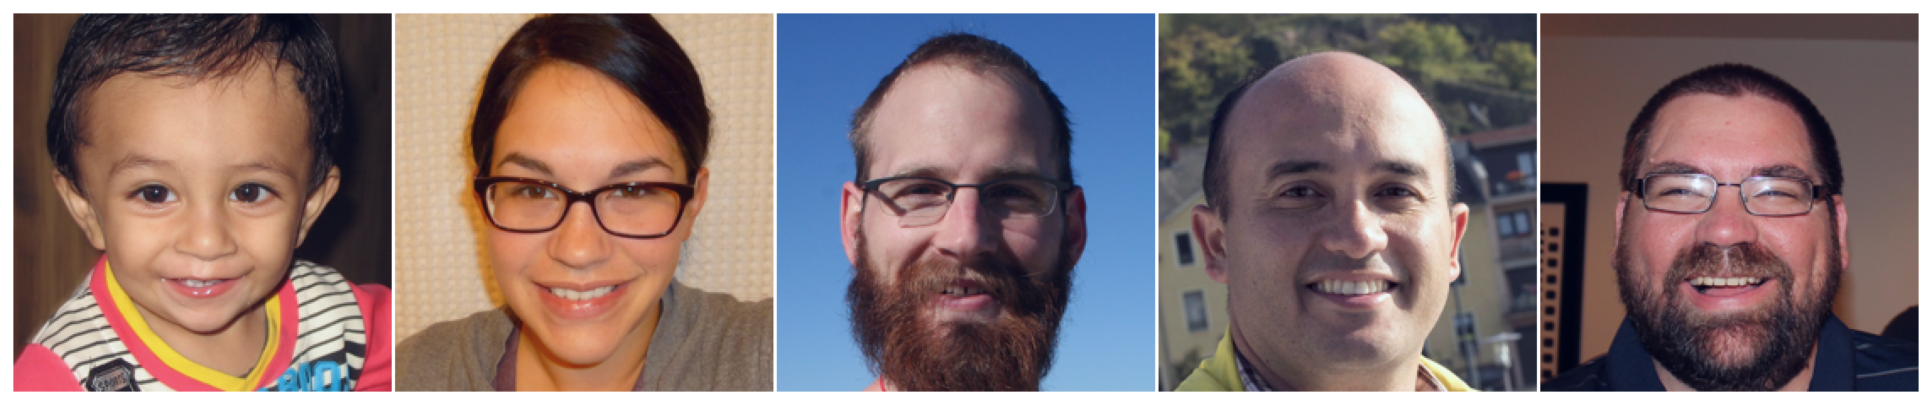

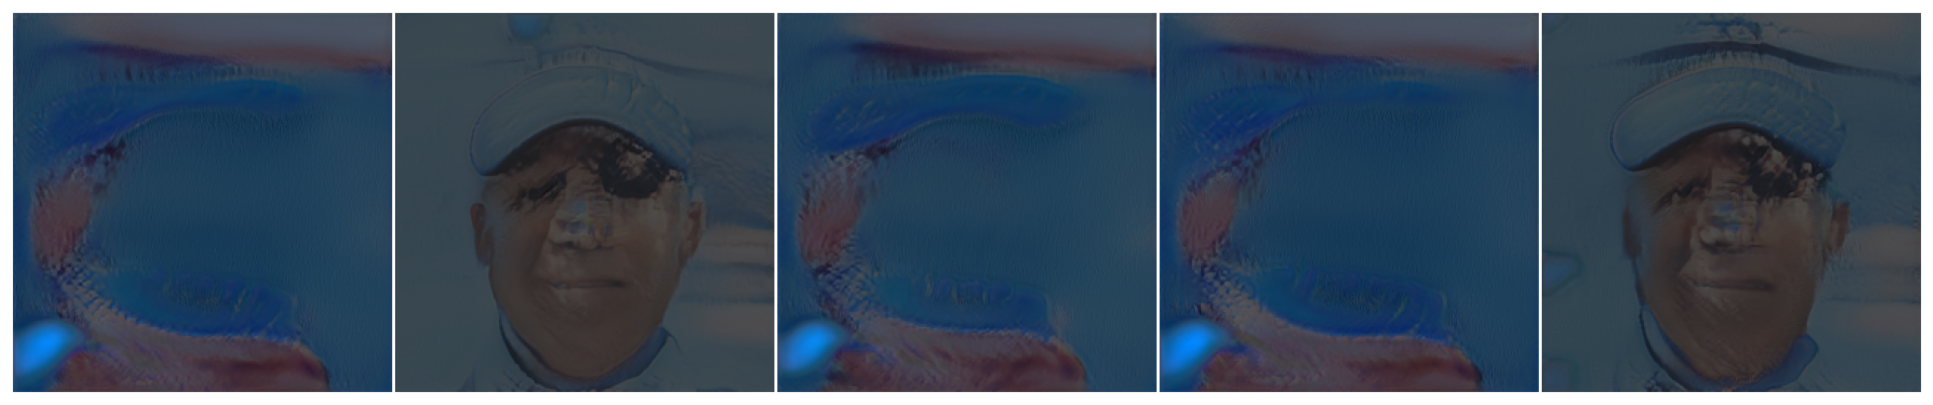

In [24]:
visualize_inversion("data/ffhq_val", mapping, G, model)

In [ ]:
from utils import plot_losses

plot_losses({"loss_hist": loss_hist})

### Learning map to w-space

In [26]:
def train_latent_map2w_sg_clip(
        mapping: nn.Module, 
        sg_generator: nn.Module, 
        encoder: nn.Module, 
        loss_fn, # loss function used on latents
        optimizer, 
        num_iters=5000, 
        batch_size=512, 
        ema=None,
        image_augmentations=None,
        args=AttributeDict(),
        plot_every=None,
    ):
    sg_generator.eval()
    encoder.eval()
    mapping.train()

    loss_hist = []
    p_bar = tqdm(range(num_iters))
    for i in p_bar:
        optimizer.zero_grad()
        z = torch.randn((batch_size, z_dim), device=DEVICE)
        with torch.no_grad():
            w = sg_generator.style(z)
            images = denormalize(predict_from_w(sg_generator, batch_size, w))
            # Saving images for later reconstruction loss
            if args.loss_reconstruction is not None:
                images_original = images.clone()
            if image_augmentations is not None:
                images = image_augmentations(images)
            images = clip_transform(images)
            y = encoder.encode_image(images).squeeze(0).float()
            if args.noise_lantents:
                y += args.nl_scale*torch.randn_like(y)
                
        if args.adv_loss_used:
            loss = loss_fn(mapping, y, w)
        else:
            w_hat = mapping(y)
            loss = loss_fn(w_hat, w)
            
        if args.loss_reconstruction is not None:
            imgs_hat = predict_from_w(sg_generator, batch_size, w_hat)
            imgs_hat = denormalize(imgs_hat)
            loss += args.rec_loss_scale * args.loss_reconstruction(imgs_hat, images_original)
        
        loss.backward()
        optimizer.step()
        if ema is not None:
            ema.update()
        
        loss_hist.append(loss.item())
        p_bar.set_postfix(loss=loss.item())
        
        if plot_every is not None:
            if i % plot_every == 0:
                clear_output(wait=True)
                visualize_inversion("data/celeba_val", mapping, sg_generator, encoder)
        
    return loss_hist, mapping


@torch.no_grad()
def visualize_inversion2w(eval_samples, mapping, generator, encoder, saved_weights_path=None):
    if saved_weights_path is not None:
        mapping.load_state_dict(torch.load(saved_weights_path))

    # read images from folder
    images = []
    for file in os.listdir(eval_samples):
        if file.split('.')[-1] not in ['jpg', 'jpeg', 'png']: continue
        img = Image.open(eval_samples + '/' + file)
        images.append(img)
    eval_samples = images
    eval_samples = [eval_transform(img) for img in eval_samples]
    plot_images(eval_samples, nrow=5)
    
    mapping.eval()
    images=torch.stack(eval_samples).to(DEVICE)
    y = encoder.encode_image(images).squeeze(0).float()
    w_hat = mapping(y)
    inv_samples = denormalize(predict_from_w(generator, len(eval_samples), w_hat)).cpu()
    # eval_samples = torch.stack(eval_samples) # for vis. function
    # eval_samples = torch.stack(eval_samples) # for vis. function
    plot_images(inv_samples, nrow=5)
    mappint.train()

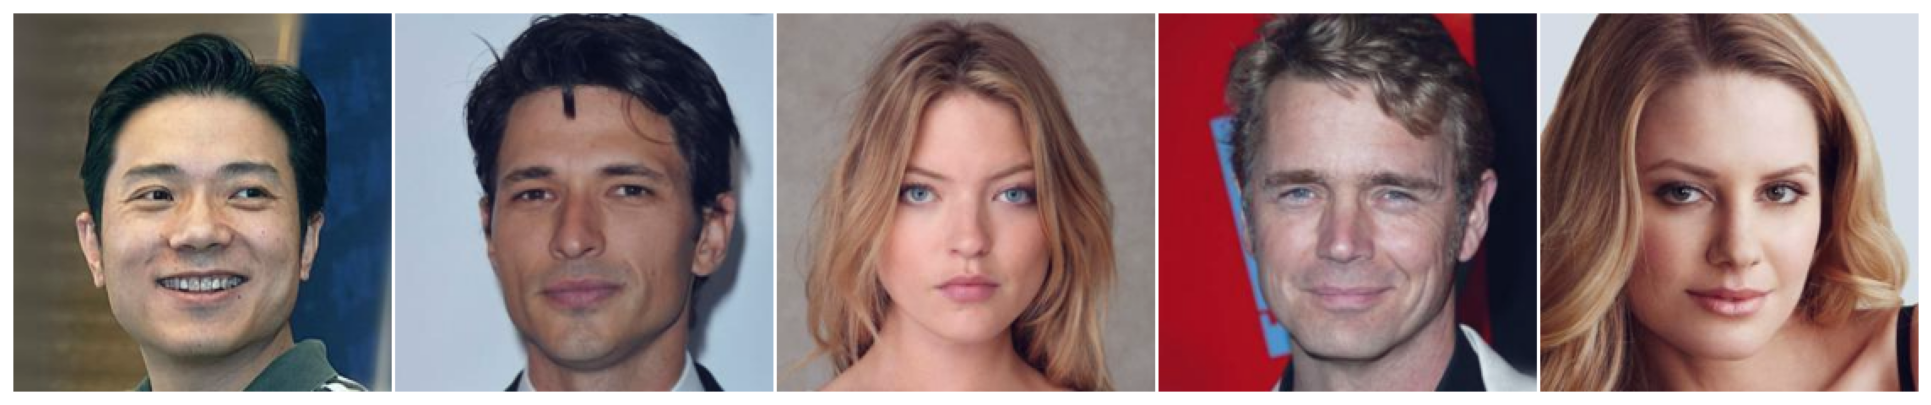

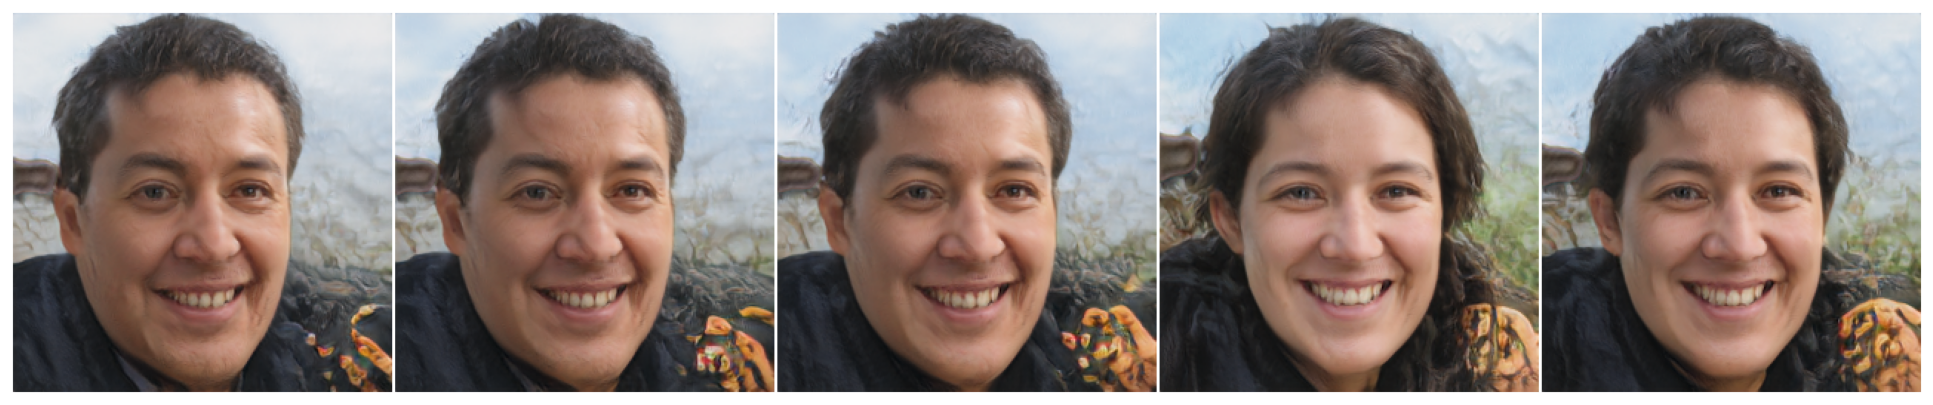

100%|████████████████████████████████████████████████████████████████| 10000/10000 [57:52<00:00,  2.88it/s, loss=0.0155]


In [28]:
# Baseline training, no tricks
z_dim=512
y_dim=512
n_hidden=4
hidden_dim=512
mapping = MLPMapv2(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)

# training utils
optimizer = optim.Adam(mapping.parameters(), lr=1e-3)
loss_fn = F.mse_loss
batch_size = 32

args = AttributeDict()
args.noise_lantents = True
args.nl_scale = 1e-1
args.adv_loss_used = False 
args.rec_loss_scale = 0. # loss(x, G(z))
args.loss_reconstruction = None

loss_hist, mapping = train_latent_map2w_sg_clip(
    mapping=mapping,
    sg_generator=G,
    encoder=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_iters=10_000,
    batch_size=batch_size,
    # image_augmentations=T.RandomErasing(),
    args=args,
    plot_every=50
)